# This is a notebook to demonstrate the following pipeline 
## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Input Data](#InputData)
1. [Feature Engineering](#FeatureEngineering)
1. [Build and Train a model](#BuildTrain)
1. [Learn important features](#LearnFeatures)
1. [Compile the model](#Compile)
1. [Deploy the model](#Deploy)
1. [Consume the model](#Consume)

## Background

This notebook has been built to showcase an end to end ML pipeline on Sagemaker with a dataset from kaggle https://www.kaggle.com/c/favorita-grocery-sales-forecasting/data. 

## Goal: 
Can we predict product sales from hundreds of supermarkets, with over 200,000 different products ? 
## Setup

This notebook was created and tested on an ml.m5.4xlarge notebook instance.

## Input Data
The training data includes dates, store and item information, whether that item was being promoted, as well as the unit sales. Additional files include supplementary information

## Exploratory analysis
First review exploratory analysis to understand the properties of the dataset here : https://www.kaggle.com/headsortails/shopping-for-insights-favorita-eda


In [2]:
%%time

import os
import boto3
import re
import pandas as pd
import numpy as np
from sagemaker import get_execution_role
import matplotlib.pyplot as plt

role = get_execution_role()
region = boto3.Session().region_name

bucket='sainsbury-workshop-regression' # put your s3 bucket name here, and create s3 bucket
prefix = 'sagemaker/DEMO-xgboost-regression'

CPU times: user 711 ms, sys: 103 ms, total: 814 ms
Wall time: 1.89 s


In [3]:
# customize to your bucket where you have stored the data
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region,bucket)

In [4]:
print(bucket)

sainsbury-workshop-regression


In [5]:
s3 = boto3.resource('s3', region_name=region)
s3.Bucket(bucket).download_file('data/favorita-grocery-sales-forecasting.zip','data/favorita-grocery-sales-forecasting.zip')


In [6]:
###Now go to the terminal and unzip all the files from command line using following commands
#1. Install 7zip on amazon linux
#yum-config-manager --enable epel
#yum install -y p7ip
#cp /usr/bin/7za /usr/bin/7z
#7z

#2. unzip data/favorita-grocery-sales-forecasting.zip

#3. Unzip all 7z data files 
#Example : 7z x train.csv.7z



In [7]:
items = pd.read_csv('data/items.csv')
holidays_events = pd.read_csv('data/holidays_events.csv')
oil = pd.read_csv('data/oil.csv')
stores = pd.read_csv('data/stores.csv')
transactions = pd.read_csv('data/transactions.csv')
df_train = pd.read_csv('data/train.csv')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [45]:
items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [10]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [11]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [12]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [13]:

holidays_events = holidays_events[['date','type']]
holidays_events.head()


,date,type
0,2012-03-02,Holiday
1,2012-04-01,Holiday
2,2012-04-12,Holiday
3,2012-04-14,Holiday
4,2012-04-21,Holiday


Here we define a sampling rate to determine the final dataset to be used for feature engineering and building a model. 

In [ ]:
sampling_rate = 0.01

In [166]:
df_train = df_train.sample(frac=sampling_rate, replace=False, random_state=1)
df_train.shape


(1254970, 6)

In [167]:
train = pd.merge(df_train, stores, on= "store_nbr")
train = pd.merge(train, items, on= "item_nbr")
train = pd.merge(train, holidays_events, on="date")
train = pd.merge(train, oil, on ="date")


## Feature Engineering
The goal of feature engineering is to provide strong and ideally simple relationships between new input features and the output feature for the supervised learning algorithm to model.

## Lag Features

Lag features are the classical way that time series forecasting problems are transformed into supervised learning problems.The simplest approach is to predict the value at the next time (t+1) given the value at the previous time (t-1). 

## Rolling Window Statistics

A step beyond adding raw lagged values is to add a summary of the values at previous time steps.
We can calculate summary statistics across the values in the sliding window and include these as features in our dataset. Perhaps the most useful is the mean of the previous few values, also called the rolling mean.

## Logarithm of counts

Time series with an exponential distribution can be made linear by taking the logarithm of the values. This is called a log transform.

## Seasonality 

Include day of the week and month of the year 


1. Rolling mean of unit sales across 5 days
2. Rolling mean of unit sales across 30 days
3. Rolling mean aggregate for different categories across perishable/non-perishable , promotion/no-promotion and different family types
4. Logarithm of count values to make the series linear and the distribution uniform. 
5. Seasonality components to include day of the week and month of the year

## Any other ideas from data exploration ??

In [168]:
#Apply rolling mean 
train.loc[(train.unit_sales<0),'unit_sales'] = 1 
rolling_mean_5 = train.groupby(['item_nbr','store_nbr'])['unit_sales'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean())
rolling_mean_family_5 = train.groupby(['family','store_nbr'])['unit_sales'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean())
rolling_mean_30 = train.groupby(['item_nbr','store_nbr'])['unit_sales'].apply(lambda x: x.shift().rolling(30, min_periods=1).mean())
rolling_mean_family_30 = train.groupby(['family','store_nbr'])['unit_sales'].apply(lambda x: x.shift().rolling(30, min_periods=1).mean())
train['unit_rolling_mean_5'] = rolling_mean_5
train['unit_rolling_mean_family_5'] = rolling_mean_family_5
train['unit_rolling_mean_30'] = rolling_mean_30
train['unit_rolling_mean_family_30'] = rolling_mean_family_30



In [169]:
#Seasonality
train['month'] = pd.DatetimeIndex(train['date']).month
train['dow'] = pd.DatetimeIndex(train['date']).dayofweek

In [170]:
#Logarithm of count values
train['unit_log_sales'] =  train['unit_sales'].apply(pd.np.log1p) 
train['unit_log_rolling_mean_5'] =  train['unit_rolling_mean_5'].apply(pd.np.log1p) 
train['unit_log_rolling_mean_family_5'] =  train['unit_rolling_mean_family_5'].apply(pd.np.log1p) 
train['unit_log_rolling_mean_30'] =  train['unit_rolling_mean_30'].apply(pd.np.log1p) 
train['unit_log_rolling_mean_family_30'] =  train['unit_rolling_mean_family_30'].apply(pd.np.log1p) 
train.tail()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,city,state,type_x,cluster,family,class,perishable,type_y,dcoilwtico,unit_rolling_mean_5,unit_rolling_mean_family_5,unit_rolling_mean_30,unit_rolling_mean_family_30,month,dow,unit_log_sales,unit_log_rolling_mean_5,unit_log_rolling_mean_family_5,unit_log_rolling_mean_30,unit_log_rolling_mean_family_30
152185,16324244,2014-01-01,36,1116113,1.000,NaN,Libertad,Guayas,E,10,GROCERY I,1004,0,Holiday,NaN,NaN,1.6000,NaN,4.000000,1,2,0.693147,NaN,0.955511,NaN,1.609438
152186,16323429,2014-01-01,25,1345067,4.000,NaN,Salinas,Santa Elena,D,1,GROCERY I,1030,0,Holiday,NaN,2.0,6.8000,2.0,5.500000,1,2,1.609438,1.098612,2.054124,1.098612,1.871802
152187,16324087,2014-01-01,36,876225,1.000,NaN,Libertad,Guayas,E,10,GROCERY I,1014,0,Holiday,NaN,NaN,1.6000,NaN,3.966667,1,2,0.693147,NaN,0.955511,NaN,1.602749
152188,16323925,2014-01-01,36,584129,4.891,NaN,Libertad,Guayas,E,10,MEATS,2302,1,Holiday,NaN,7.0,3.2908,7.0,8.260203,1,2,1.773426,2.079442,1.456473,2.079442,2.225726
152189,16324149,2014-01-01,36,1016067,2.000,NaN,Libertad,Guayas,E,10,CLEANING,3014,0,Holiday,NaN,NaN,5.4000,NaN,5.200000,1,2,1.098612,NaN,1.856298,NaN,1.824549


In [171]:
#Remove columns that are either unique and hence not informative or have a valid replacement
train = train.drop(['date','id','store_nbr', 'item_nbr','unit_sales','unit_rolling_mean_5','unit_rolling_mean_family_5','unit_rolling_mean_30','unit_rolling_mean_family_30'], axis=1)
for col in ['cluster', 'class', 'perishable','month','dow']:
    train[col] = train[col].astype('category')
type(train['cluster'])
train.head()

,onpromotion,city,state,type_x,cluster,family,class,perishable,type_y,dcoilwtico,month,dow,unit_log_sales,unit_log_rolling_mean_5,unit_log_rolling_mean_family_5,unit_log_rolling_mean_30,unit_log_rolling_mean_family_30
0,False,Guayaquil,Guayas,D,10,CLEANING,3034,0,Holiday,45.13,8,2,1.386294,NaN,NaN,NaN,NaN
1,False,Cuenca,Azuay,D,2,GROCERY I,1022,0,Holiday,45.13,8,2,3.091042,NaN,NaN,NaN,NaN
2,False,Ambato,Tungurahua,A,14,GROCERY I,1062,0,Holiday,45.13,8,2,1.609438,NaN,NaN,NaN,NaN
3,False,Daule,Guayas,D,1,POULTRY,2420,1,Holiday,45.13,8,2,1.845616,NaN,NaN,NaN,NaN
4,False,Machala,El Oro,D,4,GROCERY I,1042,0,Holiday,45.13,8,2,0.693147,NaN,NaN,NaN,NaN


In [172]:
train = train.dropna()
train.shape

(52471, 17)

,dcoilwtico,unit_log_sales,unit_log_rolling_mean_5,unit_log_rolling_mean_family_5,unit_log_rolling_mean_30,unit_log_rolling_mean_family_30
count,52471.000000,52471.000000,52471.000000,52471.000000,52471.000000,52471.000000
mean,55.820004,1.807131,1.836219,2.014500,1.836254,2.128949
std,20.278044,0.898738,0.876842,0.673993,0.876717,0.528126
min,27.960000,0.093490,0.150143,0.476545,0.150143,0.476545
25%,43.450000,1.098612,1.098612,1.526056,1.098612,1.757858
50%,48.540000,1.609438,1.704748,1.916923,1.704748,2.054124
75%,59.100000,2.312238,2.370804,2.397895,2.370804,2.433613
max,107.950000,7.080026,8.517393,6.913737,8.517393,5.660941


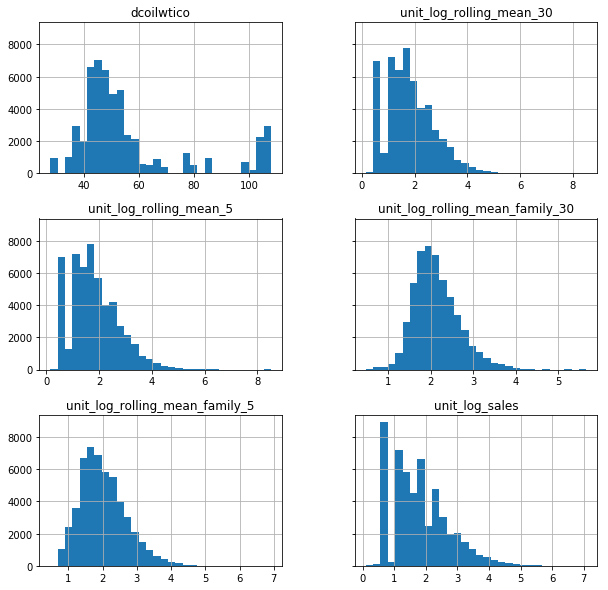

In [173]:
# Frequency tables for each categorical feature
#for column in train.select_dtypes(include=['object']).columns:
#    display(pd.crosstab(index=train[column], columns='% observations', normalize='columns'))

# Histograms for each numeric features
display(train.describe())
%matplotlib inline
hist = train.hist(bins=30, sharey=True, figsize=(10, 10))


Most of the numeric features are surprisingly nicely distributed, with many showing bell-like gaussianity. 

 Let's dig deeper into the relationships between our features.

In [174]:
display(train.corr())


,dcoilwtico,unit_log_sales,unit_log_rolling_mean_5,unit_log_rolling_mean_family_5,unit_log_rolling_mean_30,unit_log_rolling_mean_family_30
dcoilwtico,1.000000,0.000714,-0.004357,-0.030657,-0.004314,-0.024450
unit_log_sales,0.000714,1.000000,0.684104,0.314282,0.684181,0.345716
unit_log_rolling_mean_5,-0.004357,0.684104,1.000000,0.317669,0.999950,0.372900
unit_log_rolling_mean_family_5,-0.030657,0.314282,0.317669,1.000000,0.317702,0.686427
unit_log_rolling_mean_30,-0.004314,0.684181,0.999950,0.317702,1.000000,0.372956
unit_log_rolling_mean_family_30,-0.024450,0.345716,0.372900,0.686427,0.372956,1.000000


Now that we've cleaned up our dataset, let's determine which algorithm to use.  In order to accommodate different numeric ranges and large number of categorical variables in an algorithm like linear regression, we'd need to generate polynomial (or bucketed) terms. Instead, let's attempt to model this problem using gradient boosted trees. Amazon SageMaker provides an XGBoost container that we can use to train in a managed, distributed setting, and then host as a real-time prediction endpoint. XGBoost uses gradient boosted trees which naturally account for non-linear relationships between features and the target variable, as well as accommodating complex interactions between features.

Amazon SageMaker XGBoost can train on data in either a CSV or LibSVM format. For this example, we'll stick with CSV. It should:

    Have the predictor variable in the first column
    Not have a header row

But first, let's convert our categorical features into numeric features.


- Convert categorical features into numeric features
- Include 1 of the output predictor variable in the first column
- Remove the other output predictor variables

In [247]:
train = train.drop(['class'], axis=1) #too many unique class types
model_data = pd.get_dummies(train)
#set the output variable to be the first
cols = model_data.columns.tolist()
#print(cols)

#select unit_log_sales output for this model
cols = cols[1:2] + cols[:1] + cols[2:]
print(cols)
model_data = model_data[cols]

['unit_log_sales', 'dcoilwtico', 'unit_log_rolling_mean_5', 'unit_log_rolling_mean_family_5', 'unit_log_rolling_mean_30', 'unit_log_rolling_mean_family_30', 'onpromotion_False', 'onpromotion_True', 'city_Ambato', 'city_Babahoyo', 'city_Cayambe', 'city_Cuenca', 'city_Daule', 'city_El Carmen', 'city_Esmeraldas', 'city_Guaranda', 'city_Guayaquil', 'city_Ibarra', 'city_Latacunga', 'city_Libertad', 'city_Loja', 'city_Machala', 'city_Manta', 'city_Playas', 'city_Puyo', 'city_Quevedo', 'city_Quito', 'city_Riobamba', 'city_Salinas', 'city_Santo Domingo', 'state_Azuay', 'state_Bolivar', 'state_Chimborazo', 'state_Cotopaxi', 'state_El Oro', 'state_Esmeraldas', 'state_Guayas', 'state_Imbabura', 'state_Loja', 'state_Los Rios', 'state_Manabi', 'state_Pastaza', 'state_Pichincha', 'state_Santa Elena', 'state_Santo Domingo de los Tsachilas', 'state_Tungurahua', 'type_x_A', 'type_x_B', 'type_x_C', 'type_x_D', 'type_x_E', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'clu

In [248]:
#filter rows where the output variable  is not finite
model_data = model_data[np.isfinite(model_data['unit_log_sales'])]

In [251]:
model_data.shape

(52471, 123)

And now let's split the data into training, validation, and test sets. This will help prevent us from overfitting the model, and allow us to test the models accuracy on data it hasn't already seen.

In [252]:
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)

In [253]:
pd.options.display.max_columns = None
print(train_data.head())
print(train_data.shape)
print(validation_data.shape)

        unit_log_sales  dcoilwtico  unit_log_rolling_mean_5  \
124587        1.609438       55.25                 1.609438   
3261          2.302585       44.68                 1.945910   
149948        2.484907       63.13                 2.602690   
111484        2.833213       49.58                 2.302585   
77792         0.693147       43.18                 0.693147   

        unit_log_rolling_mean_family_5  unit_log_rolling_mean_30  \
124587                        2.397895                  1.609438   
3261                          2.261763                  1.945910   
149948                        1.471279                  2.602690   
111484                        2.240710                  2.302585   
77792                         1.722767                  0.693147   

        unit_log_rolling_mean_family_30  onpromotion_False  onpromotion_True  \
124587                         1.882006                  1                 0   
3261                           3.042536             

Upload the files to S3

In [254]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

## Train 
First specify the location of the XGBoost built-in algorithm container


In [255]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost', '0.90-2')#sagemaker debugger requires 0.90-2

Then, because we're training with the CSV file format, we'll create `s3_input`s that our training function can use as a pointer to the files in S3.

In [256]:
import sagemaker
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')


### Hyperparameters for XGBoost
Now, we can specify a few parameters like what type of training instances we'd like to use and how many, as well as our XGBoost hyperparameters.  A few key hyperparameters are:
- `max_depth` controls how deep each tree within the algorithm can be built.  Deeper trees can lead to better fit, but are more computationally expensive and can lead to overfitting.  There is typically some trade-off in model performance that needs to be explored between a large number of shallow trees and a smaller number of deeper trees.
- `subsample` controls sampling of the training data.  This technique can help reduce overfitting, but setting it too low can also starve the model of data.
- `num_round` controls the number of boosting rounds.  This is essentially the subsequent models that are trained using the residuals of previous iterations.  Again, more rounds should produce a better fit on the training data, but can be computationally expensive or lead to overfitting.
- `eta` controls how aggressive each round of boosting is.  Larger values lead to more conservative boosting.
- `gamma` controls how aggressively trees are grown.  Larger values lead to more conservative models.

More detail on XGBoost's hyperparmeters can be found on their GitHub [page](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md).

### Enabling Debugger in Estimator object


#### DebuggerHookConfig

Enabling Amazon SageMaker Debugger in training job can be accomplished by adding its configuration into Estimator object constructor:

```python
from sagemaker.debugger import DebuggerHookConfig, CollectionConfig

estimator = Estimator(
    ...,
    debugger_hook_config = DebuggerHookConfig(
        s3_output_path="s3://{bucket_name}/{location_in_bucket}",  # Required
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": "10"
                }
            )
        ]
    )
)
```
Here, the `DebuggerHookConfig` object instructs `Estimator` what data we are interested in.
Two parameters are provided in the example:

- `s3_output_path`: it points to S3 bucket/path where we intend to store our debugging tensors.
  Amount of data saved depends on multiple factors, major ones are: training job / data set / model / frequency of saving tensors.
  This bucket should be in your AWS account, and you should have full access control over it.
  **Important Note**: this s3 bucket should be originally created in the same region where your training job will be running, otherwise you might run into problems with cross region access.

- `collection_configs`: it enumerates named collections of tensors we want to save.
  Collections are a convinient way to organize relevant tensors under same umbrella to make it easy to navigate them during analysis.
  In this particular example, you are instructing Amazon SageMaker Debugger that you are interested in a single collection named `metrics`.
  We also instructed Amazon SageMaker Debugger to save metrics every 10 iteration.
  See [Collection](https://github.com/awslabs/sagemaker-debugger/blob/master/docs/api.md#collection) documentation for all parameters that are supported by Collections and DebuggerConfig documentation for more details about all parameters DebuggerConfig supports.
  
#### Rules

Enabling Rules in training job can be accomplished by adding the `rules` configuration into Estimator object constructor.

- `rules`: This new parameter will accept a list of rules you wish to evaluate against the tensors output by this training job.
  For rules, Amazon SageMaker Debugger supports two types:
  - SageMaker Rules: These are rules specially curated by the data science and engineering teams in Amazon SageMaker which you can opt to evaluate against your training job.
  - Custom Rules: You can optionally choose to write your own rule as a Python source file and have it evaluated against your training job.
    To provide Amazon SageMaker Debugger to evaluate this rule, you would have to provide the S3 location of the rule source and the evaluator image.

In this example, you will use a Amazon SageMaker's LossNotDecreasing rule, which helps you identify if you are running into a situation where the training loss is not going down.

```python
from sagemaker.debugger import rule_configs, Rule

estimator = Estimator(
    ...,
    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": "10",
            },
        ),
    ],
)
```

- `rule_parameters`: In this parameter, you provide the runtime values of the parameter in your constructor.
  You can still choose to pass in other values which may be necessary for your rule to be evaluated.
  In this example, you will use Amazon SageMaker's LossNotDecreasing rule to monitor the `metircs` collection.
  The rule will alert you if the tensors in `metrics` has not decreased for more than 10 steps.


- Specify hyperparameters
- Initialize XGboost estimator
- Initialize Sagemaker Debugger hooks in the estimator
- Fit the model with train and validation data



In [257]:
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig, CollectionConfig
from sagemaker.estimator import Estimator
save_interval = 5
sess = sagemaker.Session()
base_job_name = 'xgboost-regression-debugger'
hyperparameters={
    "max_depth": "5",
    "eta": "0.2",
    "gamma": "4",
    "min_child_weight": "6",
    "subsample": "0.8",
    "silent": "0",
    "objective": "reg:squarederror",
    "num_round": "51",
}

xgb_debug = Estimator(
    role=role,
    hyperparameters=hyperparameters,
    base_job_name=base_job_name,
    train_instance_count=1,
    train_instance_type='ml.m5.4xlarge',
    image_name=container,
    train_max_run=1800,
    output_path='s3://{}/{}/output'.format(bucket, prefix),
    sagemaker_session=sess,

    debugger_hook_config=DebuggerHookConfig(
        s3_output_path='s3://{}/{}/output'.format(bucket, prefix),  # Required
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
            CollectionConfig(
                name="feature_importance",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
            CollectionConfig(
                name="average_shap",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
        ],
    ),
    
    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": str(save_interval * 2),
            },
        ),
    ],

)




With the next step, start a training job by using the Estimator object you created above. This job is started in an asynchronous, non-blocking way. This means that control is passed back to the notebook and further commands can be run while the training job is progressing.

In [ ]:
xgb_debug.fit({'train': s3_input_train, 'validation': s3_input_validation},
    # This is a fire and forget event. By setting wait=False, you just submit the job to run in the background.
    # Amazon SageMaker starts one training job and release control to next cells in the notebook.
    # Follow this notebook to see status of the training job.
    wait=False
)

Evaluate status of training job and debug rule evaluation job

### Result

As a result of the above command, Amazon SageMaker starts one training job and one rule job for you. The first one is the job that produces the tensors to be analyzed. The second one analyzes the tensors to check if `train-rmse` and `validation-rmse` are not decreasing at any point during training.

Check the status of the training job below.
After your training job is started, Amazon SageMaker starts a rule-execution job to run the LossNotDecreasing rule.

**Note that the next cell blocks until the rule execution job ends. You can stop it at any point to proceed to the rest of the notebook. Once it says Rule Evaluation Status is Started, and shows the `RuleEvaluationJobArn`, you can look at the status of the rule being monitored.**

In [258]:
import time

for _ in range(360):
    job_name = xgb_debug.latest_training_job.name
    client = xgb_debug.sagemaker_session.sagemaker_client
    description = client.describe_training_job(TrainingJobName=job_name)
    training_job_status = description["TrainingJobStatus"]
    rule_job_summary = xgb_debug.latest_training_job.rule_job_summary()
    rule_evaluation_status = rule_job_summary[0]["RuleEvaluationStatus"]
    #rule_evaluation_status = "None"
    print("Training job status: {}, Rule Evaluation Status: {}".format(training_job_status, rule_evaluation_status))

    if rule_evaluation_status in ["Stopped", "IssuesFound", "NoIssuesFound"]:
        break

    time.sleep(10)

Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation

In [259]:
! python -m pip install smdebug

You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Check the status of the Rule Evaluation Job

To get the rule evaluation job that Amazon SageMaker started for you, run the command below. The results show you the `RuleConfigurationName`, `RuleEvaluationJobArn`, `RuleEvaluationStatus`, `StatusDetails`, and `RuleEvaluationJobArn`.
If the tensors meets a rule evaluation condition, the rule execution job throws a client error with `RuleEvaluationConditionMet`.

The logs of the rule evaluation job are available in the Cloudwatch Logstream `/aws/sagemaker/ProcessingJobs` with `RuleEvaluationJobArn`.

You can see that once the rule execution job starts, it identifies the loss not decreasing situation in the training job, it raises the `RuleEvaluationConditionMet` exception, and it ends the job.

In [260]:
xgb_debug.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:208480242416:processing-job/xgboost-regression-debugge-lossnotdecreasing-0c8b6e59',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2020, 2, 25, 20, 47, 5, 116000, tzinfo=tzlocal())}]

Define the concept of trial which represents a single training run
## Data Analysis - Manual

Now that you've trained the system, analyze the data.
Here, you focus on after-the-fact analysis.

You import a basic analysis library, which defines the concept of trial, which represents a single training run.

In [261]:
#import smdebug
from smdebug.trials import create_trial

s3_output_path = xgb_debug.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

[2020-02-25 20:48:24.330 ip-172-16-47-137:5120 INFO s3_trial.py:42] Loading trial debug-output at path s3://sainsbury-workshop-regression/sagemaker/DEMO-xgboost-regression/output/xgboost-regression-debugger-2020-02-25-20-38-33-645/debug-output


You can list all the tensors that you know something about. Each one of these names is the name of a tensor. The name is a combination of the feature name, which in these cases, is auto-assigned by XGBoost, and whether it's an evaluation metric, feature importance, or SHAP value.

In [ ]:
trial.tensor_names()

In [262]:
trial.tensor("train-rmse").steps()

[2020-02-25 20:48:31.339 ip-172-16-47-137:5120 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2020-02-25 20:48:32.359 ip-172-16-47-137:5120 INFO trial.py:210] Loaded all steps


[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

### Performance metrics

You can also create a simple function that visualizes the training and validation errors as the training progresses.
Each gradient should get smaller over time, as the system converges to a good solution.
Remember that this is an interactive analysis. You are showing these tensors to give an idea of the data.

In [273]:
import matplotlib.pyplot as plt
import seaborn as sns
import re


def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals

def plot_collection(trial, collection_name, regex='.*', figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and 
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    sns.despine()
    #print(collection_name)
    tensors = trial.collection(collection_name).tensor_names
    #print(tensors)
    for tensor_name in sorted(tensors):
        #print(tensor_name)
        if re.match(regex, tensor_name):
            steps, data = get_data(trial, tensor_name)
            #print(np.mean(np.abs(data)))
            if np.mean(np.abs(data)) > 0.001 :
                ax.plot(steps, data, label=tensor_name)
            
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Iteration')
    
def plot_tensors(trial, tensors, regex='.*', figsize=(8, 6)):
    """
    Takes a `trial` and tensor names, and 
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    sns.despine()
    #print(tensors)
    #tensors = trial.collection(collection_name).tensor_names
    #print(tensors)
    for tensor_name in sorted(tensors):
        #print(tensor_name)
        if re.match(regex, tensor_name):
            steps, data = get_data(trial, tensor_name)
            if np.mean(np.abs(data)) > 0.05 :
                ax.plot(steps, data, label=tensor_name)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Iteration')

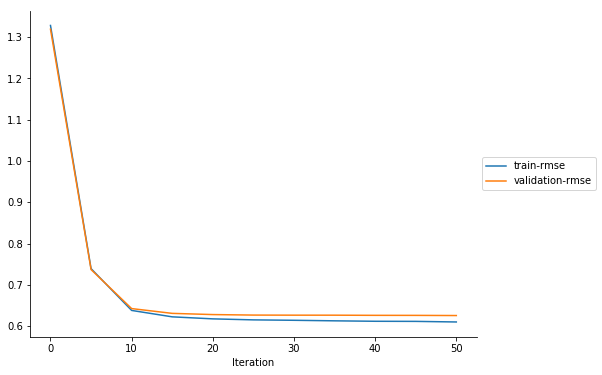

In [264]:
plot_collection(trial, "metrics")

### Feature importances

You can also visualize the feature priorities as determined by
[xgboost.get_score()](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score).
If you instructed Estimator to log the `feature_importance` collection, all five importance types supported by `xgboost.get_score()` will be available in the collection.

In [265]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    #plot_collection(trial,"feature_importance",regex=f"feature_importance/{importance_type}/.*")
    plot_tensors(trial,trial.tensor_names(),regex=f"feature_importance/{importance_type}/.*")

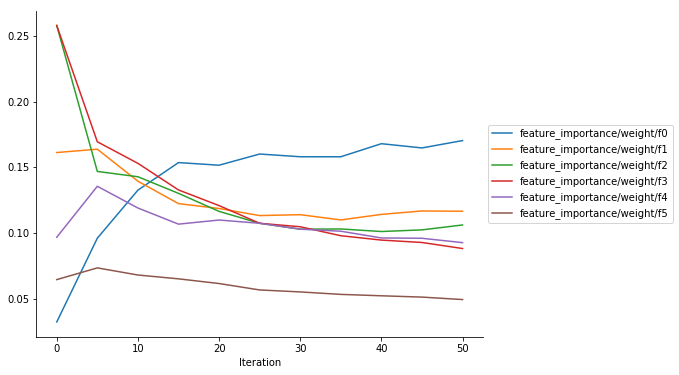

In [266]:
plot_feature_importance(trial)

### SHAP

[SHAP](https://github.com/slundberg/shap) (SHapley Additive exPlanations) is
another approach to explain the output of machine learning models.
SHAP values represent a feature's contribution to a change in the model output.
You instructed Estimator to log the average SHAP values in this example so the SHAP values (as calculated by [xgboost.predict(pred_contribs=True)](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.predict)) will be available the `average_shap` collection.

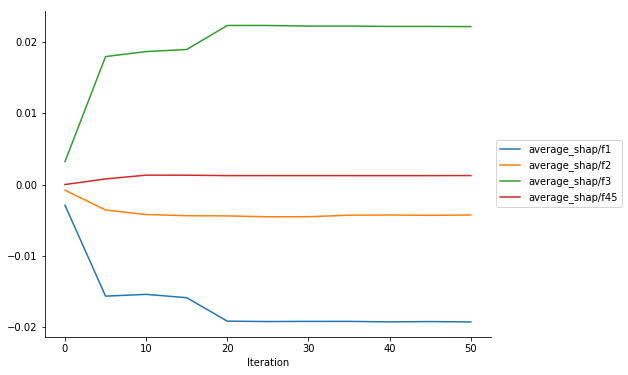

In [274]:
plot_collection(trial,"average_shap")

In [276]:
print(train_data.columns[3])

unit_log_rolling_mean_family_5


In [277]:
print(output_path)

s3://sainsbury-workshop-regression/sagemaker/DEMO-xgboost-regression


## Deploy the model as an endpoint
Now that we've trained the algorithm, let's create a model and deploy it to a hosted endpoint.

In [278]:
xgb_predictor = xgb_debug.deploy(initial_instance_count = 1, instance_type = 'ml.t2.medium')

-------------------------!

## Consume the model with test data

### Evaluate

Now that we have a hosted endpoint running, we can make real-time predictions from our model very easily, simply by making an http POST request.  But first, we'll need to setup serializers and deserializers for passing our `test_data` NumPy arrays to the model behind the endpoint.

In [279]:
from sagemaker.predictor import csv_serializer
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

Now, we'll use a simple function to:
1. Loop over our test dataset
1. Split it into mini-batches of rows 
1. Convert those mini-batchs to CSV string payloads
1. Retrieve mini-batch predictions by invoking the XGBoost endpoint
1. Collect predictions and convert from the CSV output our model provides into a NumPy array

In [280]:
def predict(data, rows=10):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        res = xgb_predictor.predict(array).decode('utf-8')
        #print(res)
        #print(array)
        predictions = ','.join([predictions, res])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.as_matrix()[:, 1:])
labels = test_data['unit_log_sales']

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


There are many ways to compare the performance of a machine learning model, but let's start by simply by comparing actual to predicted values.  

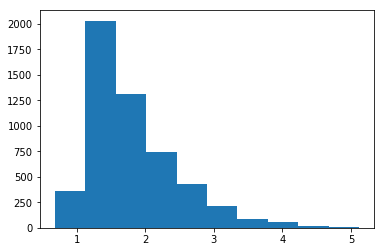

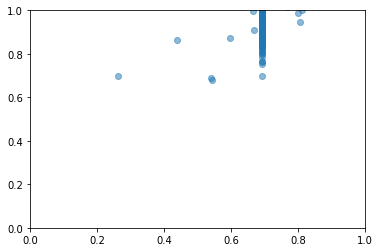

        unit_log_sales  dcoilwtico  unit_log_rolling_mean_5  \
124587        1.609438       55.25                 1.609438   
3261          2.302585       44.68                 1.945910   
149948        2.484907       63.13                 2.602690   
111484        2.833213       49.58                 2.302585   
77792         0.693147       43.18                 0.693147   

        unit_log_rolling_mean_family_5  unit_log_rolling_mean_30  \
124587                        2.397895                  1.609438   
3261                          2.261763                  1.945910   
149948                        1.471279                  2.602690   
111484                        2.240710                  2.302585   
77792                         1.722767                  0.693147   

        unit_log_rolling_mean_family_30  onpromotion_False  onpromotion_True  \
124587                         1.882006                  1                 0   
3261                           3.042536             

In [281]:
plt.hist(predictions)
plt.show()
plt.xlim(0,1)
plt.ylim(0,1)
plt.scatter(labels, predictions,  alpha=0.5)
plt.show()
#print(train_data.head())

## Test evaluation accuracy

We use Median Absolute Percent Error (The middle value of all the percentage errors for a data set when the absolute values of the errors (negative signs are ignored) are ordered by size.)


and Mean Square Error (the mean squared error (MSE) or mean squared deviation (MSD) of an estimator (of a procedure for estimating an unobserved quantity) measures the average of the squares of the errors—that is, the average squared difference between the estimated values and the actual value.)



In [282]:
print('\n Median Absolute Percent Error (MdAPE) = ', np.median(np.abs(np.array(labels) - np.array(predictions)) / np.array(labels)))


 Median Absolute Percent Error (MdAPE) =  0.22193123653819147


In [283]:
print('\n Mean Square Error (MSE) = ', np.mean(np.abs(np.array(labels) - np.array(predictions)) *np.abs(np.array(labels) - np.array(predictions)) ))


 Mean Square Error (MSE) =  0.3911043279403968
